In [28]:
# based on https://pennylane.ai/qml/demos/tutorial_learning_few_data/
# try amplitudeEmbeding on real HW

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax;

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import optax  # optimization using jax

import pennylane as qml
import pennylane.numpy as pnp

sns.set()

seed = 0
rng = np.random.default_rng(seed=seed)

Information: <br>
4 qubits, 'ibm_cairo', CX-depth=20,  some swaps were needed, job: https://quantum.ibm.com/jobs/cpsbff5sp83g0086z010 <br>

In [30]:
num_wires = 4
X=np.random.rand(2 ** num_wires)
X/=np.linalg.norm(X)
print('true X:',X)
print('true X^2:',X*X)

true X: [0.05023203 0.31480456 0.1064954  0.40122981 0.25190135 0.33372824
 0.02036676 0.42425869 0.05839599 0.00808273 0.16589468 0.01865181
 0.02660474 0.29670996 0.32801301 0.37832212]
true X^2: [2.52325664e-03 9.91019104e-02 1.13412710e-02 1.60985358e-01
 6.34542918e-02 1.11374537e-01 4.14804967e-04 1.79995436e-01
 3.41009166e-03 6.53304792e-05 2.75210453e-02 3.47890145e-04
 7.07812357e-04 8.80368003e-02 1.07592537e-01 1.43127628e-01]


In [61]:
devType='ibmq'
#devType='penny'
devType='aer'
shots=1000

if devType=='ibmq':
    backN='ibm_cairo'
    backN='ibm_hanoi'
    #backN='ibmq_kolkata'
    #backN='ibmq_qasm_simulator'
    #backN='simulator_statevector'
    from qiskit_ibm_provider import IBMProvider
    provider = IBMProvider()
    backend = provider.get_backend(backN)
    dev = qml.device('qiskit.ibmq', wires=num_wires, backend=backend, shots=shots)

if devType=='aer':
    from qiskit_aer import AerSimulator
    backend = AerSimulator()
    dev = qml.device('qiskit.ibmq', wires=num_wires, backend=backend, shots=shots)

if devType=='penny':
    dev = qml.device('default.qubit', wires=num_wires, shots=shots)

def encoder( features):
    wires = list(range(num_wires))
    qml.AmplitudeEmbedding(features=features, wires=wires, pad_with=0.5, normalize=True)
    return qml.probs(wires=wires)

qnode = qml.QNode(encoder, dev)
print('backend:',backend)
print(qml.draw(qnode)(X)) 

#fig, ax = qml.draw_mpl(encoder)( X); plt.show()

backend: AerSimulator('aer_simulator')
0: ─╭|Ψ⟩─┤ ╭Probs
1: ─├|Ψ⟩─┤ ├Probs
2: ─├|Ψ⟩─┤ ├Probs
3: ─╰|Ψ⟩─┤ ╰Probs


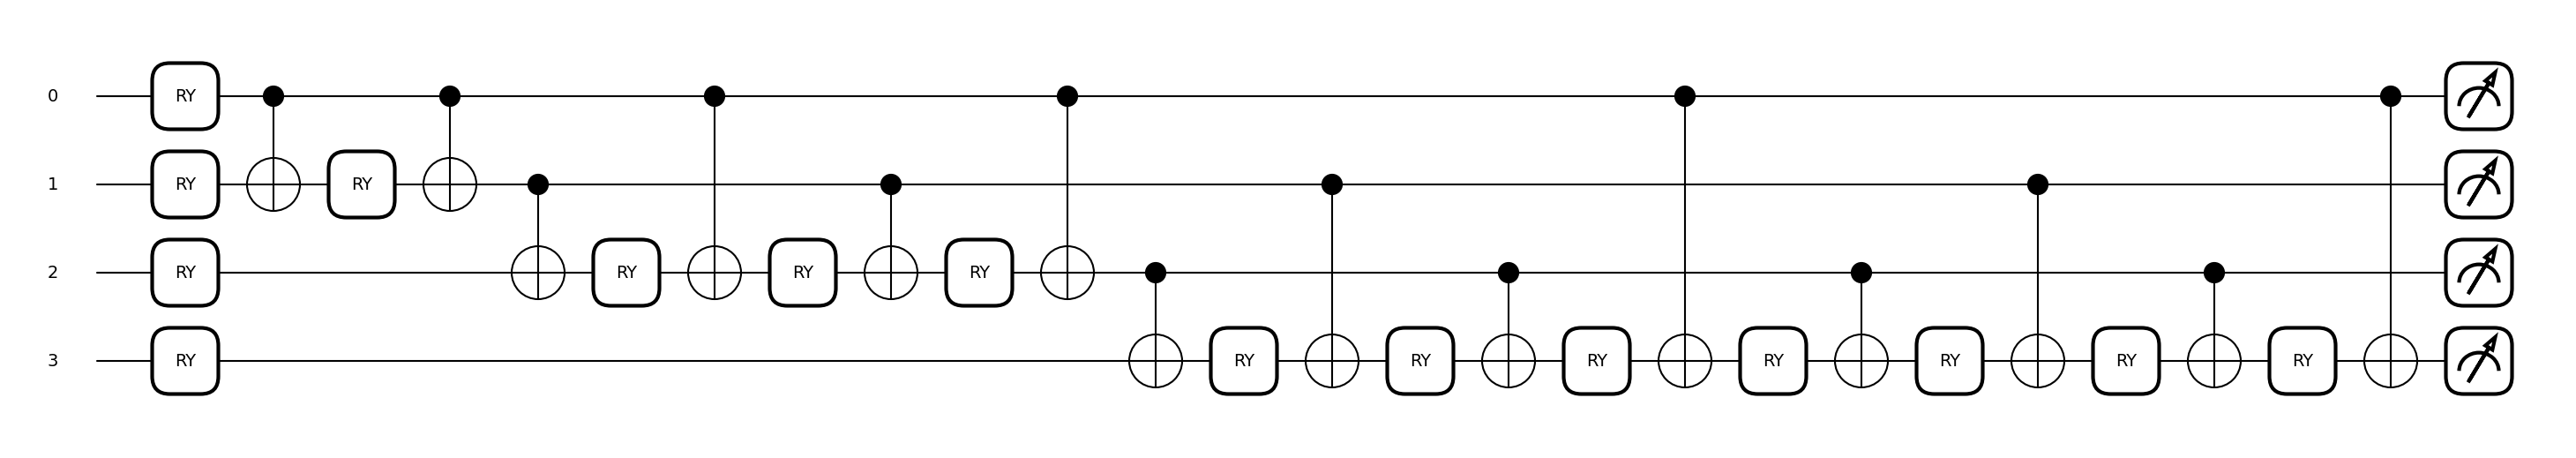

In [62]:
# compile
circT = qml.compile(encoder, basis_set=["CNOT", "RX", "RY", "RZ"], num_passes=2)
fig, ax = qml.draw_mpl(circT)( X); plt.show()

In [63]:
# run circuit
probTens = qnode(X)  # >>> pennylane.numpy.tensor.tensor
# Print the probabilities
print('backend:',backend)

maxErr=max(abs(X*X-probTens))
print('Max error in prob=%.3f'%maxErr)

print("Probability of each computational basis state:")
for state, prob in enumerate(probTens):
    print("State %2d=%s  prob=%.3f"%(state,format(state, '04b'),prob))

backend: AerSimulator('aer_simulator')
Max error in prob=0.027
Probability of each computational basis state:
State  0=0000  prob=0.001
State  1=0001  prob=0.093
State  2=0010  prob=0.019
State  3=0011  prob=0.177
State  4=0100  prob=0.069
State  5=0101  prob=0.103
State  6=0110  prob=0.000
State  7=0111  prob=0.186
State  8=1000  prob=0.005
State  9=1001  prob=0.000
State 10=1010  prob=0.023
State 11=1011  prob=0.000
State 12=1100  prob=0.001
State 13=1101  prob=0.107
State 14=1110  prob=0.100
State 15=1111  prob=0.116


In [57]:
maxErr=max(abs(X*X-probTens))
print('Max error in prob=%.3f'%maxErr)

Max error in prob=0.058


In [34]:
print('true X:',X)
print('true X^2:',X*X)
print('true counts:',int(X*X*shots))
print('meas Prob:',probTens)

true X: [0.05023203 0.31480456 0.1064954  0.40122981 0.25190135 0.33372824
 0.02036676 0.42425869 0.05839599 0.00808273 0.16589468 0.01865181
 0.02660474 0.29670996 0.32801301 0.37832212]
true X^2: [2.52325664e-03 9.91019104e-02 1.13412710e-02 1.60985358e-01
 6.34542918e-02 1.11374537e-01 4.14804967e-04 1.79995436e-01
 3.41009166e-03 6.53304792e-05 2.75210453e-02 3.47890145e-04
 7.07812357e-04 8.80368003e-02 1.07592537e-01 1.43127628e-01]


TypeError: only size-1 arrays can be converted to Python scalars

### cairo, 4 qubits
X/sqrt(prob): 
array([1.08099894, 0.9841257 , 0.50081524, 0.42169776, 0.59779001,
       0.17866984, 1.09976648, 0.93497899, 0.92159094, 1.27808848,
       0.48622436, 0.86841483, 1.20065863, 1.09142813, 1.11802098,
       0.12419242])

https://quantum.ibm.com/jobs/cpsev8x0f6rg008x52q0

### Hanoi, 5 qubits,
https://quantum.ibm.com/jobs/cpssat3d7p30008faqxg
CX-depth=69

X=array([0.25482462, 0.12445164, 0.00476081, 0.10860932, 0.15830299,
       0.09223114, 0.03781551, 0.0197818 , 0.22094702, 0.13909844,
       0.04645485, 0.03679671, 0.3037068 , 0.15292737, 0.30688205,
       0.27348676, 0.25524815, 0.2190369 , 0.14905937, 0.21808447,
       0.18815533, 0.15612455, 0.16958898, 0.06157128, 0.26991267,
       0.1306968 , 0.07553564, 0.09502198, 0.00555945, 0.22082209,
       0.24444741, 0.16625695])

probTens=array([0.042 , 0.0416, 0.0059, 0.0278, 0.0527, 0.0214, 0.0193, 0.0142,
       0.0381, 0.0205, 0.015 , 0.0152, 0.0499, 0.0151, 0.0458, 0.0589,
       0.0377, 0.051 , 0.029 , 0.0465, 0.0292, 0.0305, 0.0357, 0.0203,
       0.0461, 0.0304, 0.0171, 0.0188, 0.0161, 0.0657, 0.0172, 0.0253])

(X*X-probTens)*shots=array([ 229.35588044, -261.11790391,  -58.77334647, -160.04014764,
       -276.40164513, -128.93416268, -178.6998691 , -138.08680527,
        107.17584717,  -11.51623563, -128.4194662 , -138.46002391,
        423.37817727,   82.86780738,  483.76593974,  158.95009786,
        274.51618854,  -30.22837535,  -67.81305233,   10.60838213,
         62.02428197,  -61.251263  ,  -69.39576593, -165.08977279,
        267.52850899, -133.18347204, -113.94367526,  -97.70822599,
       -160.69092519, -169.3760602 ,  425.54534783,   23.4137347 ])

### Hanoi, 4 qubits,    sum of |residua|  = 3467 shots of 5000 shots

https://quantum.ibm.com/jobs/cpsxxed0f6rg008x6080
CX-depth=29

max(abs(X*X-probTens))=0.058

X=array([0.05023203, 0.31480456, 0.1064954 , 0.40122981, 0.25190135,
       0.33372824, 0.02036676, 0.42425869, 0.05839599, 0.00808273,
       0.16589468, 0.01865181, 0.02660474, 0.29670996, 0.32801301,
       0.37832212])

probTens=array([0.0167, 0.1234, 0.0185, 0.1417, 0.0619, 0.1175, 0.0228, 0.1247,
       0.0176, 0.0166, 0.0348, 0.0144, 0.0362, 0.0484, 0.1193, 0.0855])


(X*X-probTens)*shots=array([-141.7674336 , -242.98089616,  -71.58729041,  192.85357637,
         15.54291842,  -61.25463269, -223.85195033,  552.9543584 ,
       -141.89908344, -165.34669521,  -72.78954722, -140.52109855,
       -354.92187643,  396.36800266, -117.0746334 ,  576.27628158])

In [40]:
int(sum(abs((X*X-probTens)*shots)))

3467

In [41]:
X

array([0.05023203, 0.31480456, 0.1064954 , 0.40122981, 0.25190135,
       0.33372824, 0.02036676, 0.42425869, 0.05839599, 0.00808273,
       0.16589468, 0.01865181, 0.02660474, 0.29670996, 0.32801301,
       0.37832212])

In [42]:
probTens

array([0.0167, 0.1234, 0.0185, 0.1417, 0.0619, 0.1175, 0.0228, 0.1247,
       0.0176, 0.0166, 0.0348, 0.0144, 0.0362, 0.0484, 0.1193, 0.0855])

In [44]:
(X*X-probTens)*shots

array([-141.7674336 , -242.98089616,  -71.58729041,  192.85357637,
         15.54291842,  -61.25463269, -223.85195033,  552.9543584 ,
       -141.89908344, -165.34669521,  -72.78954722, -140.52109855,
       -354.92187643,  396.36800266, -117.0746334 ,  576.27628158])